### Basic data analysis or exploratory data analysis (EDA)

In [2]:
!pip install --upgrade seaborn pandas


In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
%matplotlib inline

In [4]:
# dataset 의 로드 index  이름 없는 데이터 드랍 
training_data = pd.read_csv('./data/cs-training.csv')
training_data = training_data.drop('Unnamed: 0', axis = 1)


# 헤더 네임 - 제거 
cleancolumn = []
for i in range(len(training_data.columns)):
    cleancolumn.append(training_data.columns[i].replace('-', '').lower())
training_data.columns = cleancolumn

###  DATA 속성의 의미

- SeriousDlqin2yrs : 지난 2년 동안 심각한 연체 기록이 있는지
- RevolvingUtilizationOfUnsecuredLines : 신용카드와 개인 신용 한도의 사용 비율
- NumberOfTime30-59DaysPastDueNotWorse : 30일에서 59일 사이 연체된 적이 몇 번 있는지
- DebtRatio : 월 소득 비 부채 비율 
- MonthlyIncome : 월 수입


In [5]:
# Null 값 ( = 누락된 데이터) ~> 중앙값을 대체
# training_data[training_data.columns[1:]].median()
# Null 값 ( = 누락된 데이터) ~> 평균값을 대체 
# training_data[training_data.columns[1:]].mean()

In [6]:
# 타겟 레아블 percentage


total = len(training_data) 
numberOfIsSeriousDlqin2yrs = training_data['seriousdlqin2yrs'].value_counts() #지난 2년 동안 심각한 연체 기록이 있는 사람 수 

percentage_labels = (numberOfIsSeriousDlqin2yrs/total)*100 #지난 2년 동안 심각한 연체 기록이 있는 사람 비율 


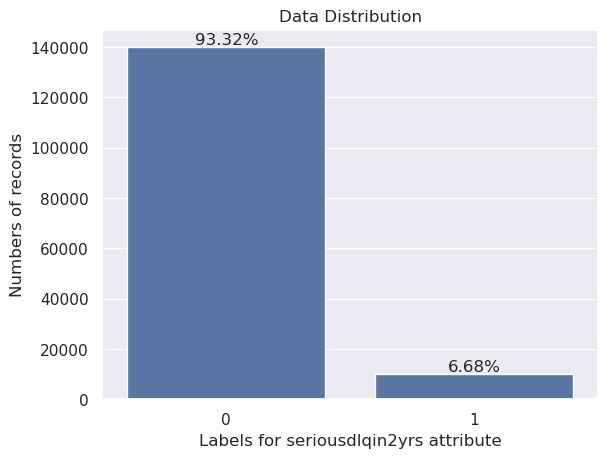

In [7]:
# #지난 2년 동안 심각한 연체 기록이 있는 사람 비율 그리기 
sns.set()

# sns.countplot을 호출할 때 'x'와 'data'를 키워드 인자로 사용
sns.countplot(x='seriousdlqin2yrs', data=training_data).set_title('Data Distribution')
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    # total_len을 계산하기 위해 len() 함수를 사용
    total_len = len(training_data['seriousdlqin2yrs'])
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100 * (height / total_len)),
            fontsize=12, ha='center', va='bottom')
sns.set(font_scale=0.5)
ax.set_xlabel("Labels for seriousdlqin2yrs attribute")
ax.set_ylabel("Numbers of records")
plt.show()


### Missing values

In [8]:
# None 처리 된 데이터가 몇개 있는지 확인
numberOfNullData = training_data.isnull().sum()

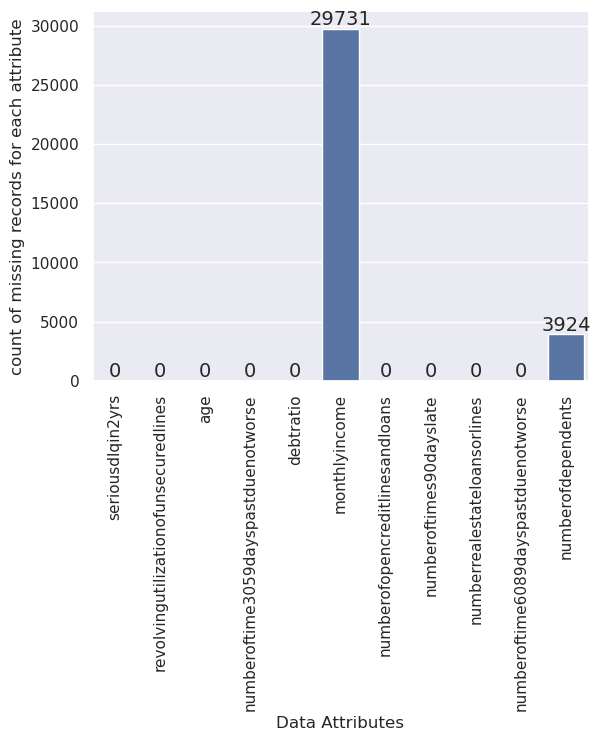

In [9]:
# None 처리된 비율 그리기
# ---------------

x = training_data.columns
y = numberOfNullData

sns.set()
sns.barplot(y)

ax = plt.gca()

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            int(height),
            fontsize=14, ha='center', va='bottom')
sns.set(font_scale=1.5)

ax.set_xlabel("Data Attributes")
ax.set_ylabel("count of missing records for each attribute")
plt.xticks(rotation=90)
plt.show()

### Null 대체 

In [10]:
# Null 값 ( = 누락된 데이터) ~> 평균값을 대체 
training_data_mean_replace = training_data.fillna((training_data.mean()))
# training_data_mean_replace.head()

In [11]:
# Actual replacement of the missing value using median value.
training_data_median_replace = training_data.fillna((training_data.median()))
# training_data_median_replace.head()

In [12]:
# training_data 중앙값으로 업데이트
training_data.fillna((training_data.median()), inplace=True)

### 연관성 확인하기 
training_data.columns[1:] 는 SeriousDlqin2yrs 을 제외한 속성들 

corr() 은 상관계수 구하는 메서드 
- 1에 가까울수록 완벽한 양의 선형 관계
- -1에 가까울수록 완벽한 음의 선형 관계
- 0은 변수 간에 선형적 관계가 없음


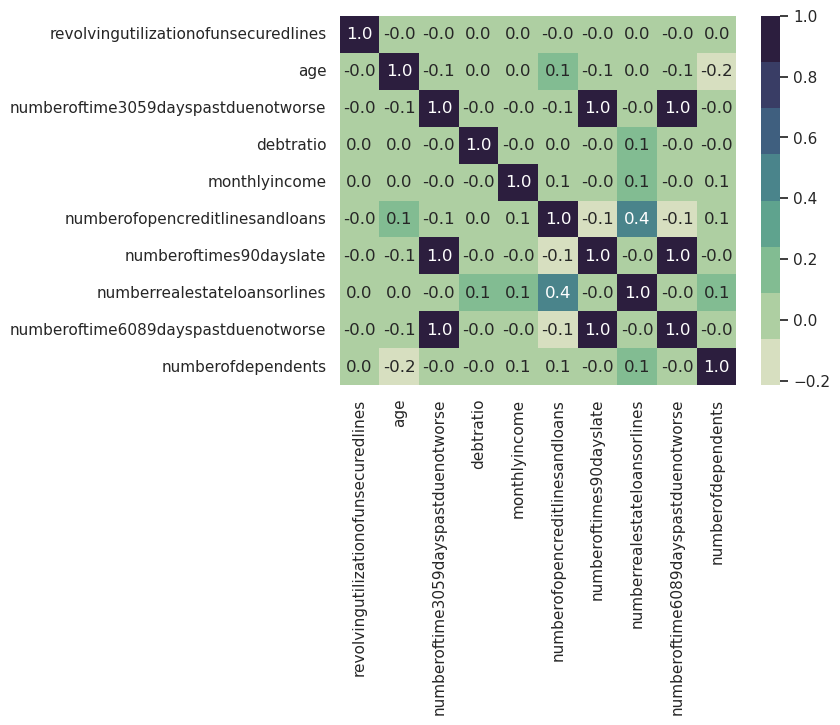

In [13]:
# training_data[training_data.columns[1:]].corr()
sns.set()
sns.heatmap(training_data[training_data.columns[1:]].corr(),annot=True,fmt=".1f",
            cmap=(sns.cubehelix_palette(8, start=.5, rot=-.75)))
plt.show()

### 이상치 탐지 (신뢰도 범위 밖 데이터 처리 )

In [14]:
#  백분위(%) 기반 이상값 처리 메서드 
# --> 상위 k% , 하위 k% 는 이상치 로 판단 

# percentile_based_outlier
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (minval, maxval) = np.percentile(data, [diff, 100 - diff])
    return ((data < minval) | (data > maxval))

# mad_based_outlier
def mad_based_outlier(points, thresh=3.5):
    # points를 numpy 배열로 변환
    if len(points.shape) == 1:
        points = np.array(points)[:, None]
    median_y = np.median(points, axis=0)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in points], axis=0)
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
    return np.abs(modified_z_scores) > thresh

# std_div
def std_div(data, threshold=3): # threshold: 이상치로 간주되는 기준값
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if val/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

# outlierVote
def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    # zip 객체를 list로 변환
    temp = list(zip(data.index, x, y, z))
    final = []
    for item in temp:
        # item.count(False) 대신에 sum을 사용하여 False의 개수를 계산
        if sum(not flag for flag in item[1:]) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final
#std_div(data=training_data.age)
#outlierVote(data=training_data.age)

In [15]:
# 함수는 주어진 데이터셋 x에 대해 네 가지 이상치 탐지 방법을 시각적으로 비교하는 데 사용됩니다.     
def plotOutlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.kdeplot(x, ax=ax, fill=True)
        sns.rugplot(x, ax=ax, color="g")
        
        # 이상치 식별
        outlier_mask = func(x)
        # 안전한 인덱싱 방법 사용
        if isinstance(outlier_mask, np.ndarray) or isinstance(outlier_mask, pd.Series):
            outliers = x.loc[outlier_mask] if isinstance(x, pd.Series) else x[outlier_mask]
            ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    # 제목 설정 및 그림 크기 조정
    set_plot_titles_and_adjust_fig_size(axes, fig, len(x))

def set_plot_titles_and_adjust_fig_size(axes, fig, n):
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(n), size=20)
    fig.set_size_inches(15, 10)


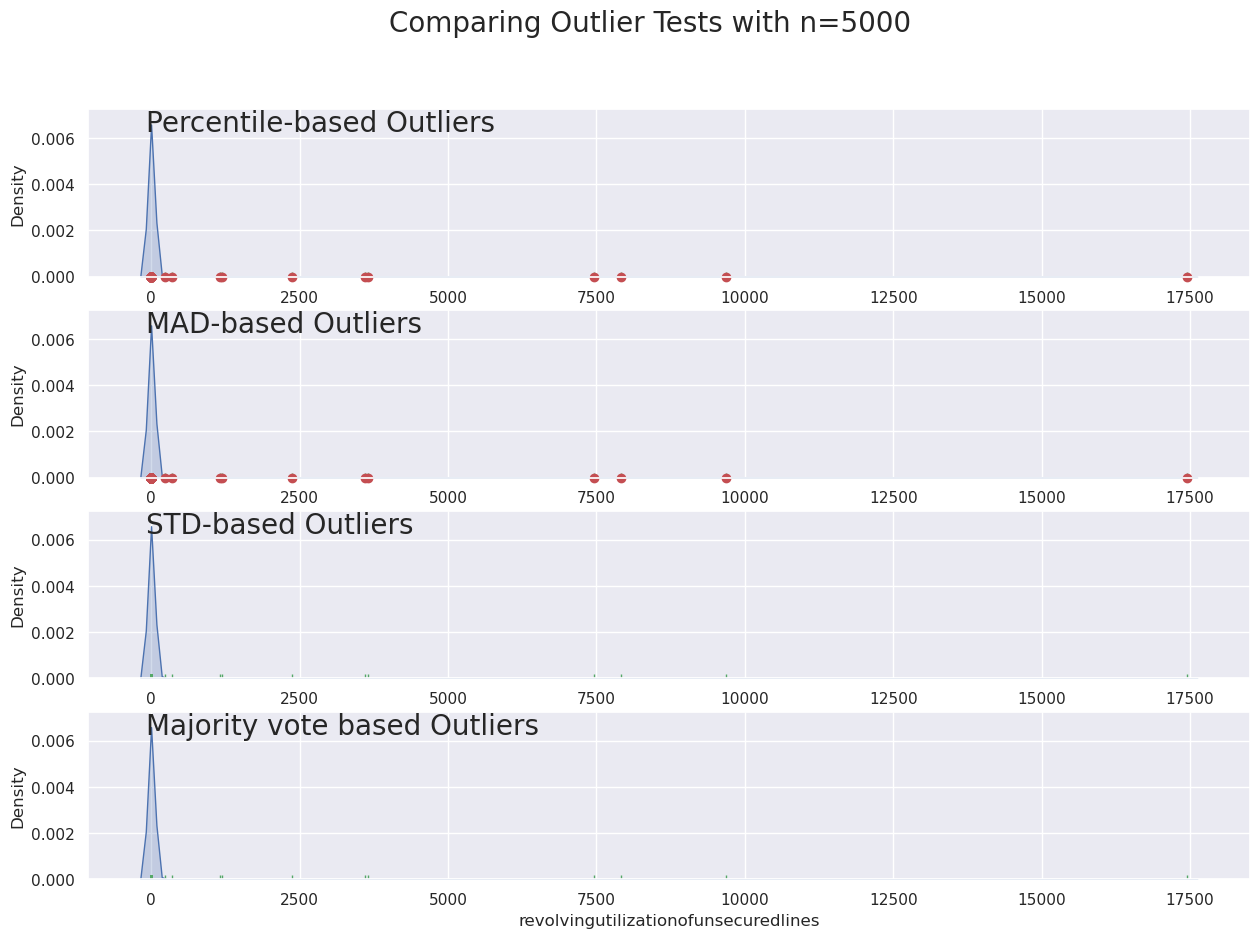

In [16]:
plotOutlier(training_data.revolvingutilizationofunsecuredlines.sample(5000))

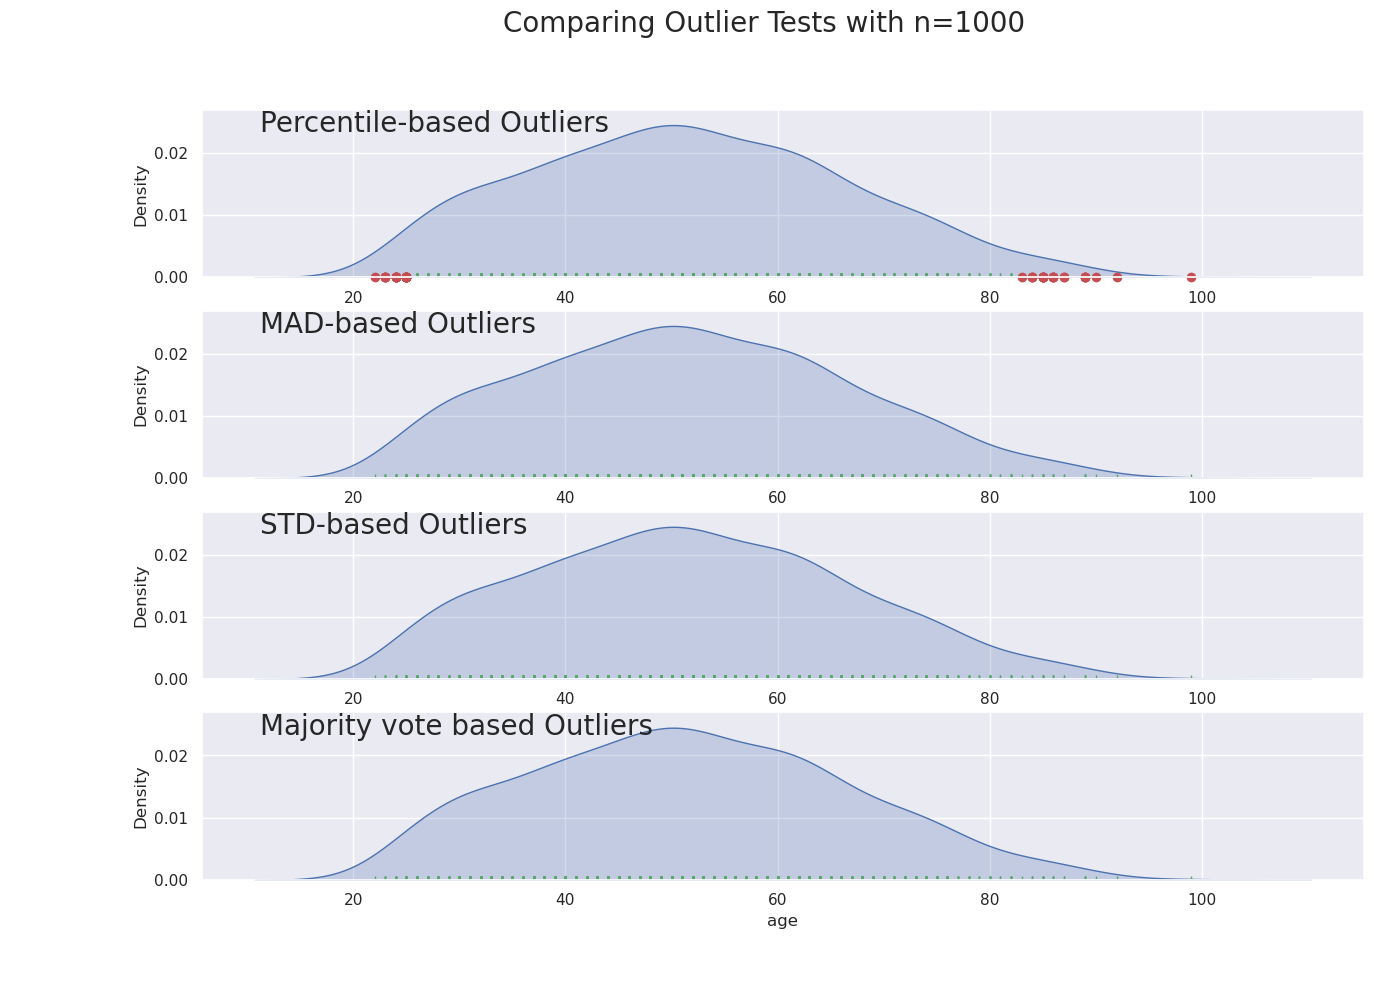

In [17]:
plotOutlier(training_data.age.sample(1000))

/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]


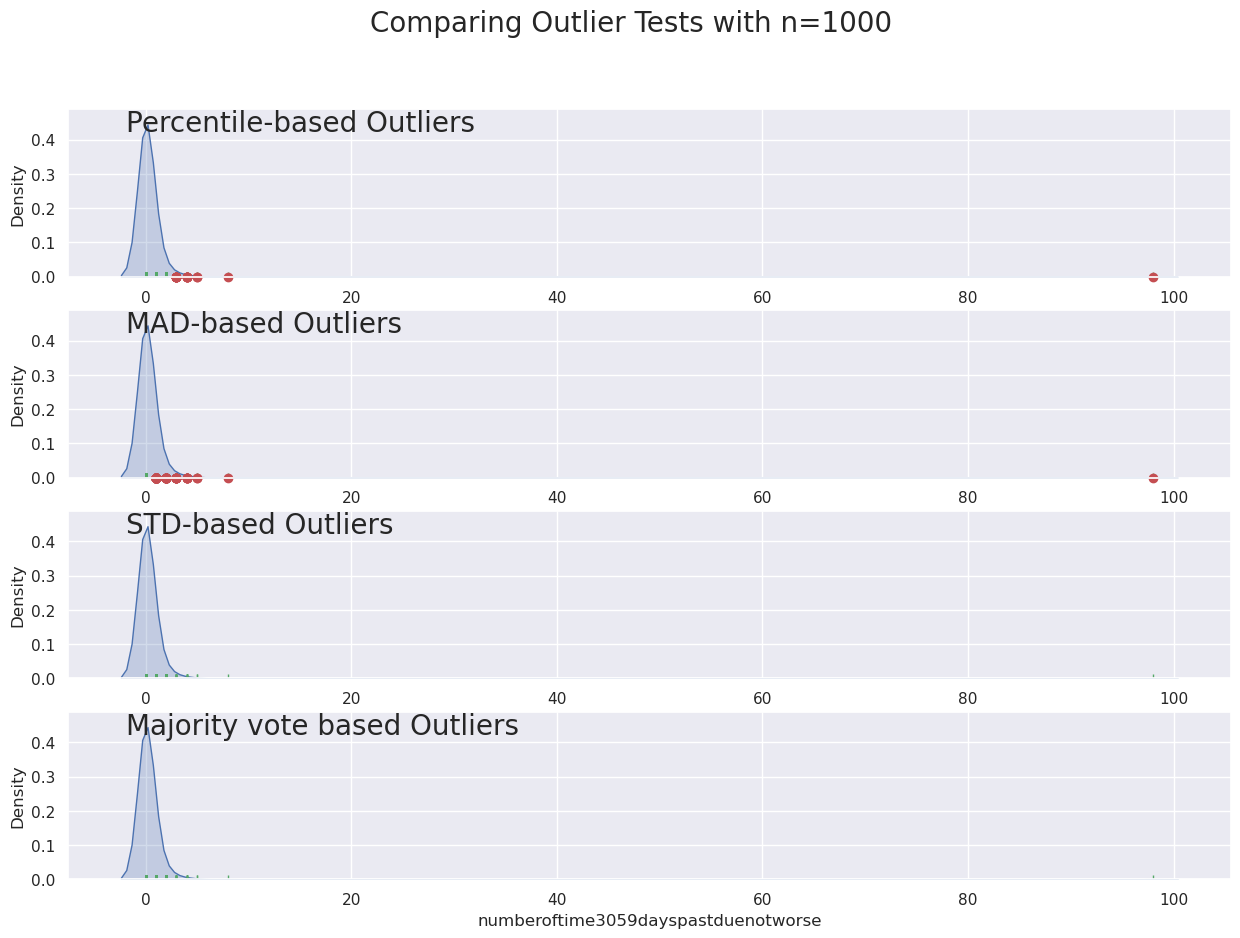

In [18]:
plotOutlier(training_data.numberoftime3059dayspastduenotworse.sample(1000))

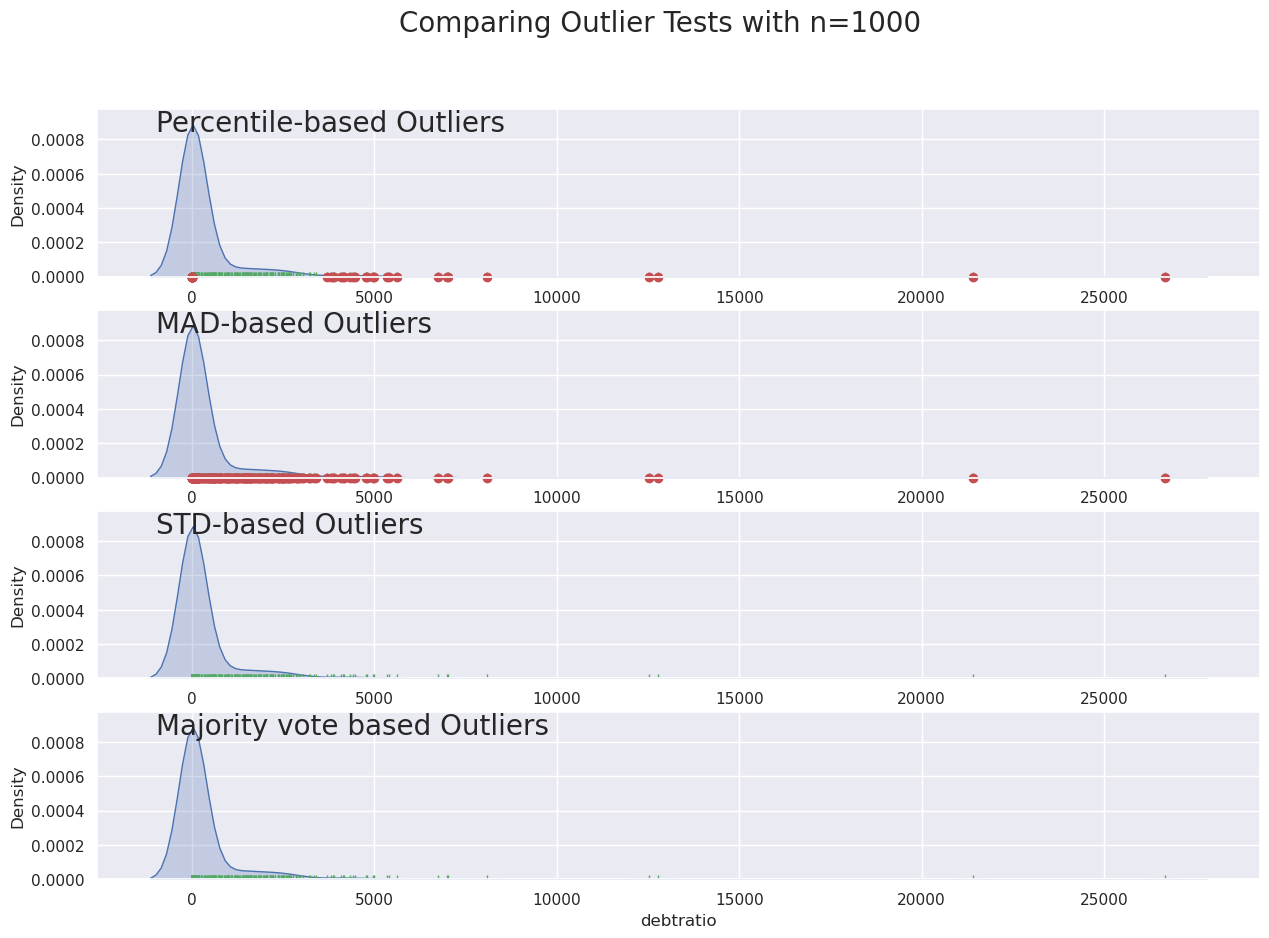

In [19]:
plotOutlier(training_data.debtratio.sample(1000))

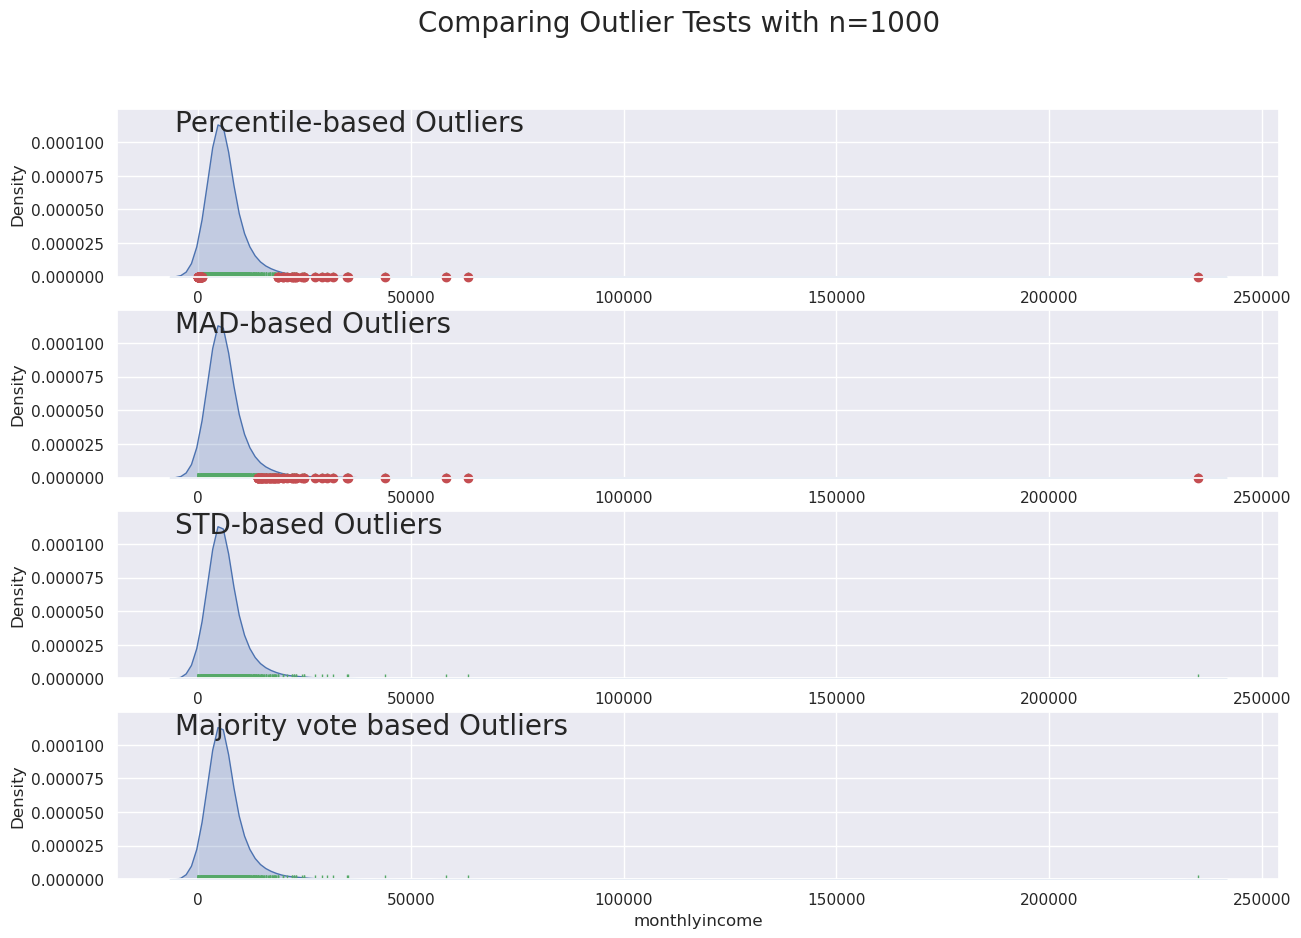

In [20]:
plotOutlier(training_data.monthlyincome.sample(1000))

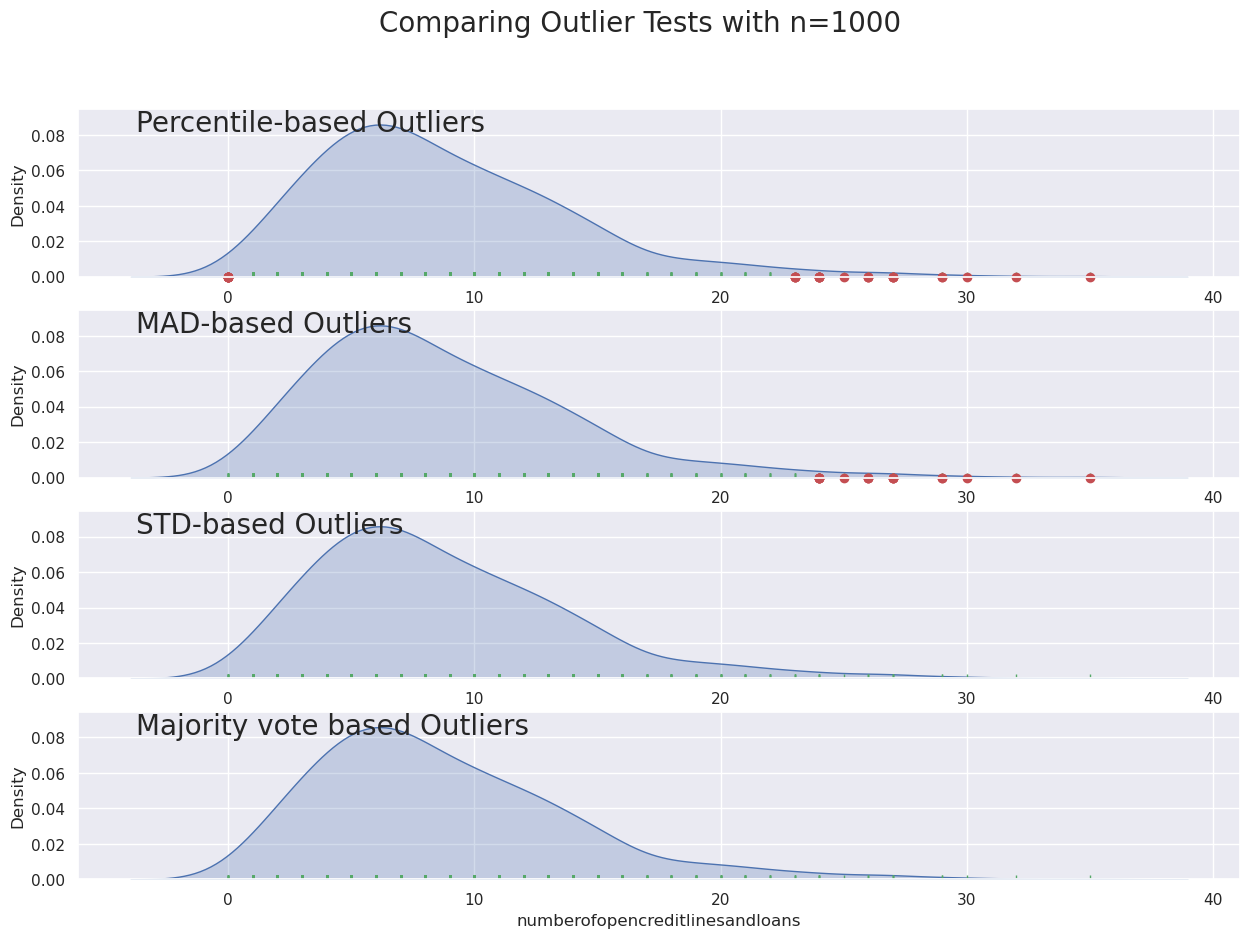

In [21]:
plotOutlier(training_data.numberofopencreditlinesandloans.sample(1000))

/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]


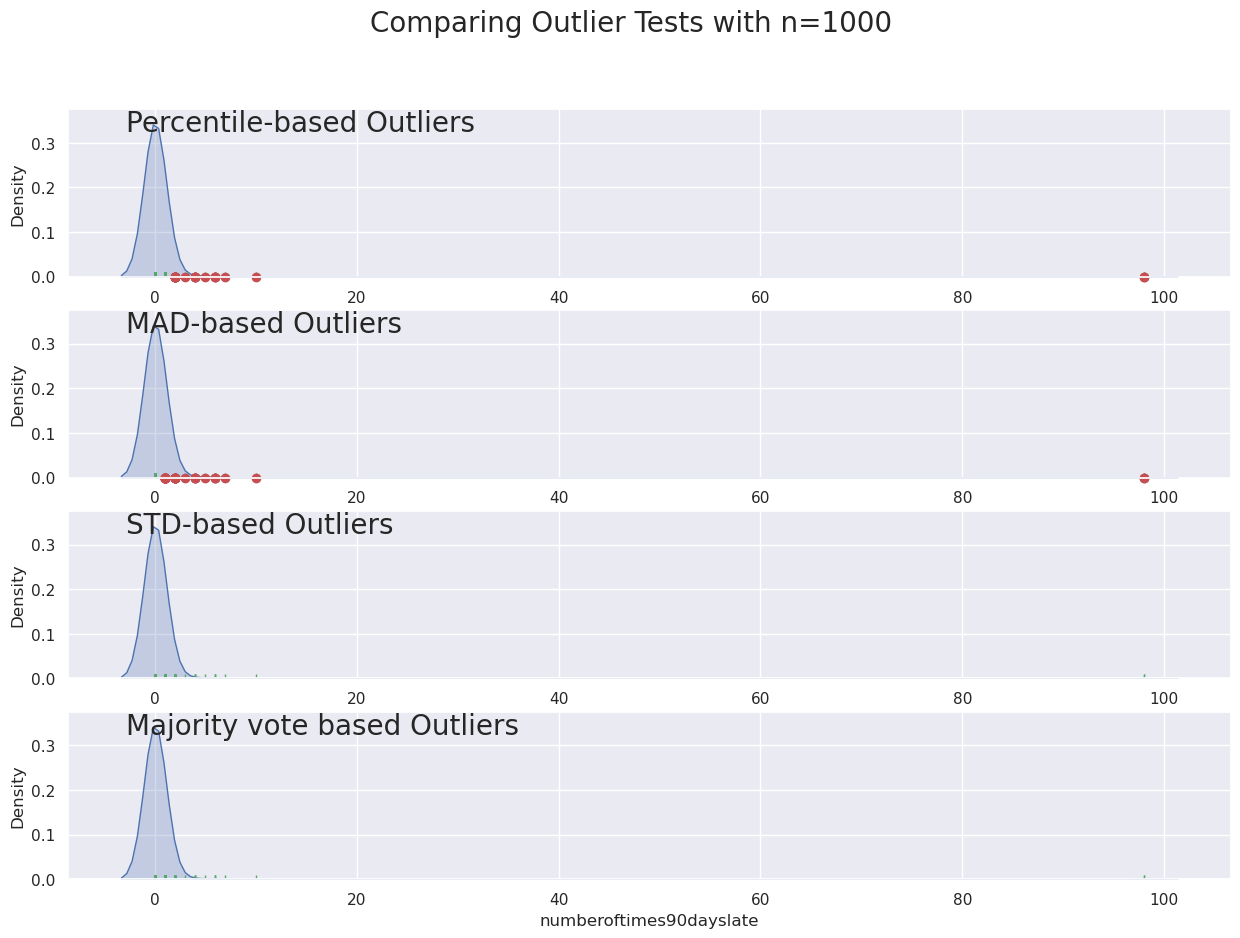

In [22]:
plotOutlier(training_data.numberoftimes90dayslate.sample(1000))

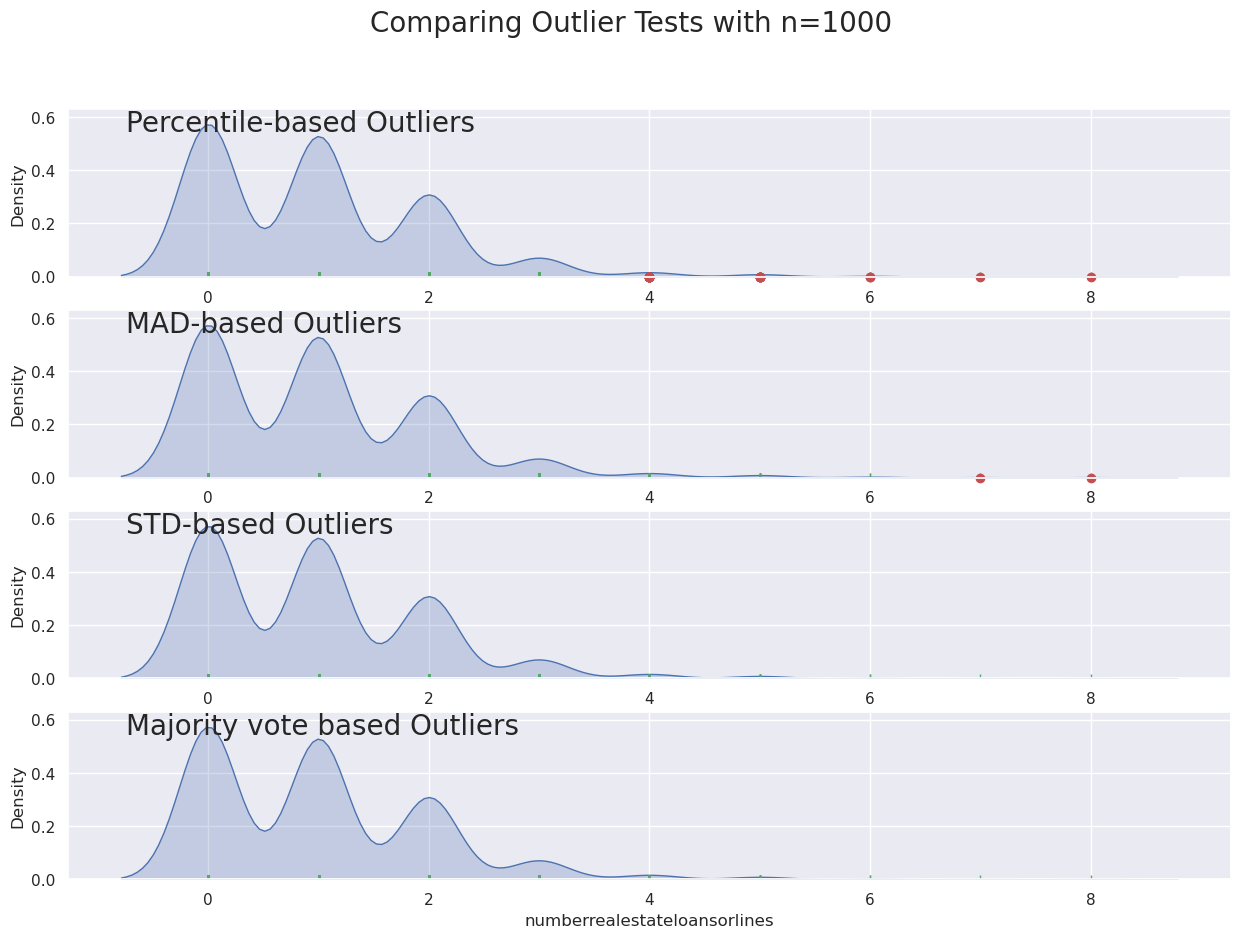

In [23]:
plotOutlier(training_data.numberrealestateloansorlines.sample(1000))

/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]


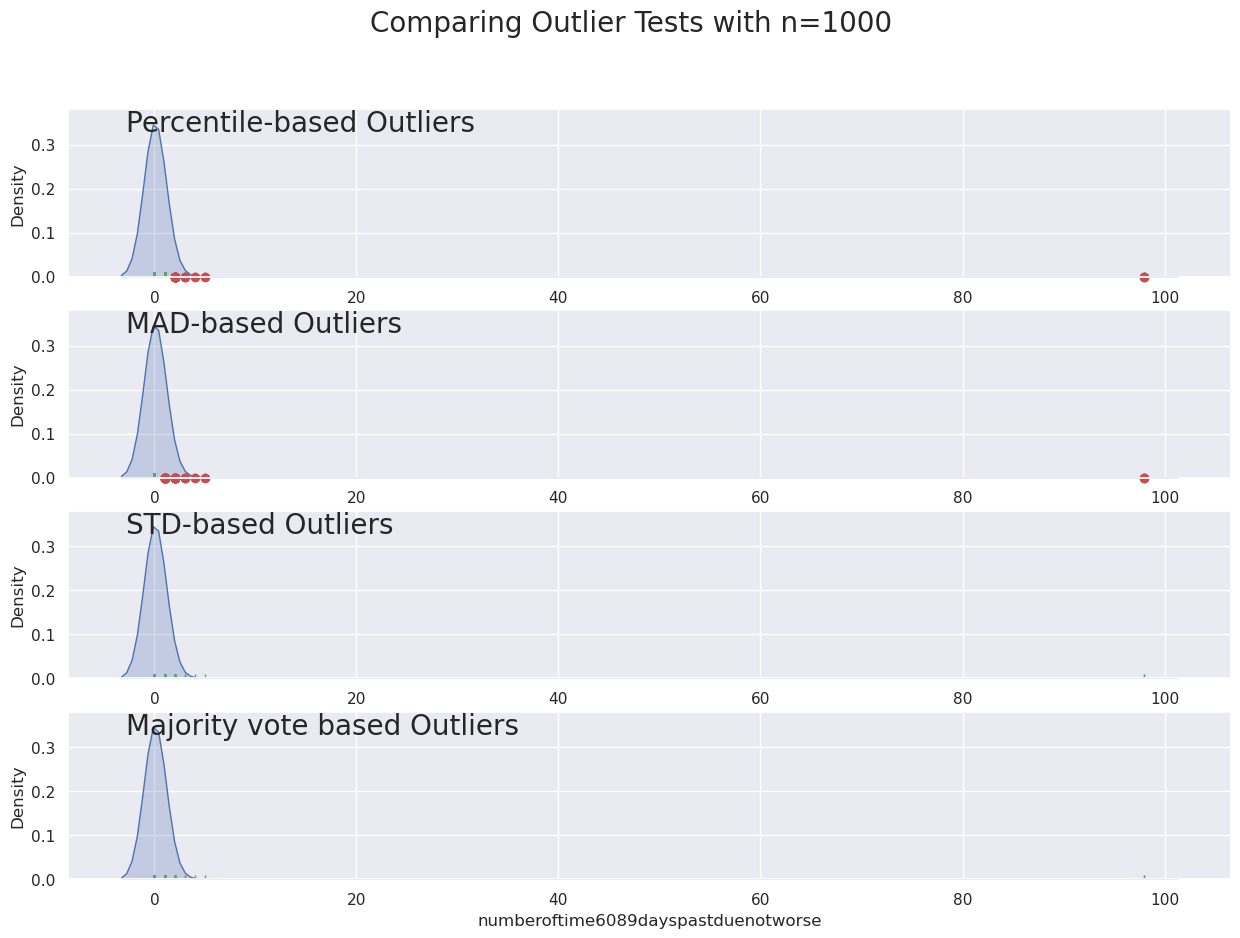

In [24]:
plotOutlier(training_data.numberoftime6089dayspastduenotworse.sample(1000))

/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_3814/3611282455.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]


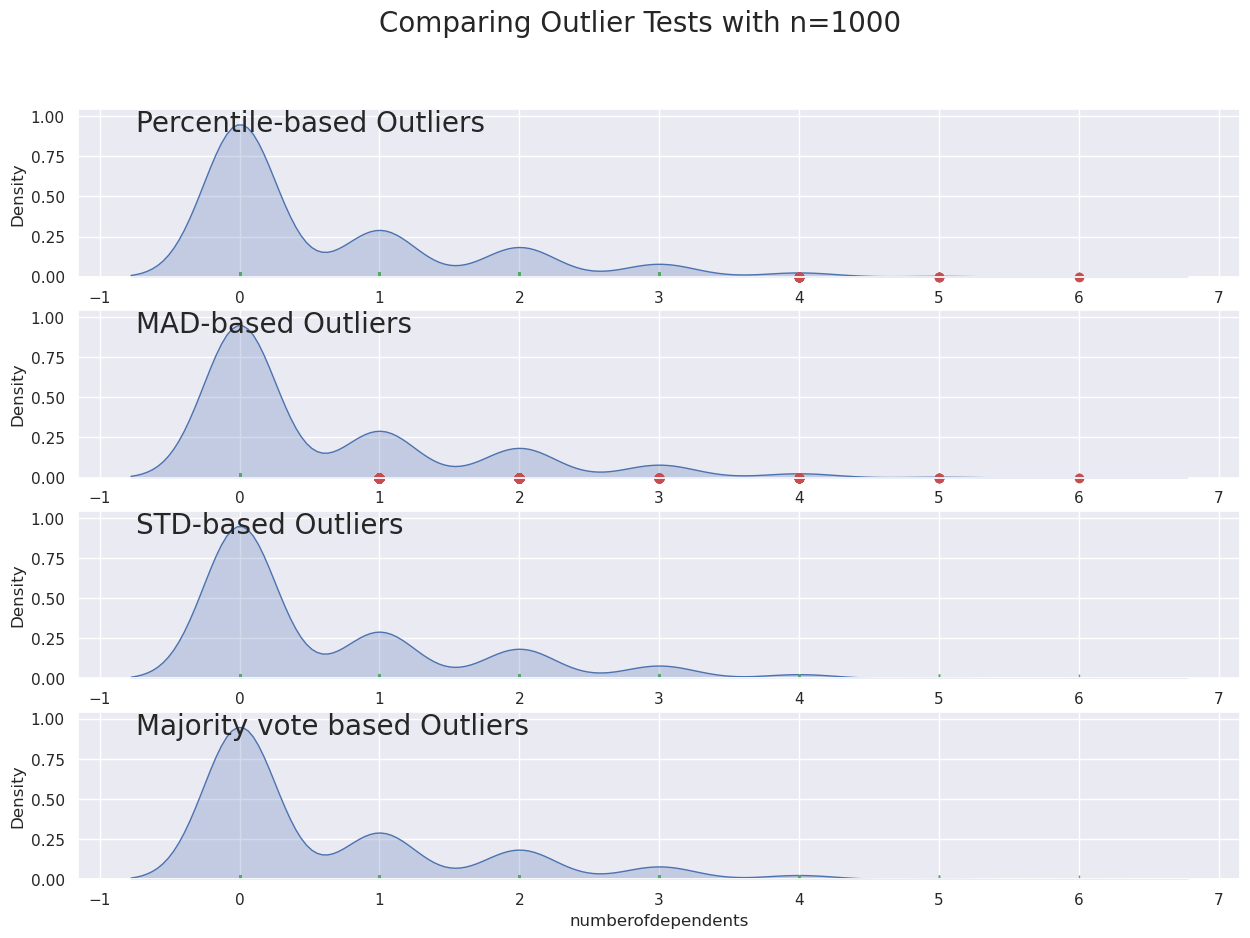

In [25]:
plotOutlier(training_data.numberofdependents.sample(1000))

### 신용사용비율 상한 처리 

In [26]:
revNew = []

# training_data.revolvingutilizationofunsecuredlines 
# 신용카드와 개인 신용 한도의 사용 비율

for val in training_data.revolvingutilizationofunsecuredlines:
    if val <= 0.99999:
        revNew.append(val)
    else: # 비율 상한처리 
        revNew.append(0.99999)
        
training_data.revolvingutilizationofunsecuredlines = revNew

In [27]:
# training_data.age.plot.box()

In [28]:
# collections.Counter(training_data.age)

### 나이 하한 처리 

In [29]:
ageNew = []
for val in training_data.age:
    if val > 21:
        ageNew.append(val)
    else:
        ageNew.append(21)
        
training_data.age = ageNew

In [30]:
# collections.Counter(training_data.numberoftime3059dayspastduenotworse)

### 연체 횟수 특정값 처리 

In [31]:
# numberoftime3059dayspastduenotworse
# 30일에서 59일 사이 연체된 적이 몇 번 있는지
New = []
med = training_data.numberoftime3059dayspastduenotworse.median()
for val in training_data.numberoftime3059dayspastduenotworse:
    if ((val == 98) or (val == 96)):
        New.append(med)
    else:
        New.append(val)

training_data.numberoftime3059dayspastduenotworse = New

In [32]:
# outlierRatio 함수는 주어진 데이터셋에 대해 네 가지 이상치 탐지 방법을 적용
# 각 방법별 이상치의 수
# 전체 이상치의 비율을 계산하여 결과를 반환

def outlierRatio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]
    outlierDict = {}
    for func in functions:
        funcResult = func(data)
        count = 0
        for val in funcResult:
            if val == True:
                count += 1 
        outlierDict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlierDict
outlierRatio(training_data.debtratio)

{'percentile_based_outlier': [3750, '2.50%'],
 'mad_based_outlier': [31727, '21.15%'],
 'std_div': [779, '0.52%'],
 'outlierVote': [3750, '2.50%']}

In [33]:
# plotOutlier(training_data.debtratio.sample(1000))

In [34]:
# def add_freq():
#     ncount = len(training_data)

#     ax2=ax.twinx()

#     ax2.yaxis.tick_left()
#     ax.yaxis.tick_right()

#     ax.yaxis.set_label_position('right')
#     ax2.yaxis.set_label_position('left')

#     ax2.set_ylabel('Frequency [%]')

#     for p in ax.patches:
#         x=p.get_bbox().get_points()[:,0]
#         y=p.get_bbox().get_points()[1,1]
#         ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
#                 ha='center', va='bottom')

#     ax2.set_ylim(0,100)
#     ax2.grid(None)
# ax = sns.countplot(mad_based_outlier(training_data.debtratio))

# add_freq()

In [35]:
minUpperBound = min([val for (val, out) in zip(training_data.debtratio, mad_based_outlier(training_data.debtratio)) if out == True])

### 월 소득 비 부채 비율 하한 처리 

In [36]:
# 
newDebtRatio = []
for val in training_data.debtratio:
    if val > minUpperBound:
        newDebtRatio.append(minUpperBound)
    else:
        newDebtRatio.append(val)

training_data.debtratio = newDebtRatio 

In [37]:
# 이상치를 제거한 후, 이상치를 제거한 데이터의 분포를 시각화

def plotOutlierFree(x):
    fig, axes = plt.subplots(nrows=4)
    nOutliers = []
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        outlier_mask = func(x)
        
        # 결과가 ndarray이고 2차원인 경우, 1차원으로 변환
        if isinstance(outlier_mask, np.ndarray) and outlier_mask.ndim > 1:
            outlier_mask = outlier_mask.ravel()
        
        # ndarray 또는 list를 Pandas Series로 변환
        if not isinstance(outlier_mask, pd.Series):
            outlier_mask = pd.Series(outlier_mask, index=x.index)

        # 이상치가 아닌 데이터 선택
        non_outliers = x.loc[~outlier_mask]
        nOutliers.append(sum(outlier_mask))  # 이상치 수 계산
        sns.kdeplot(non_outliers, ax=ax, fill=True)  # KDE 플롯 시각화

    

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile-based Outliers, removed: {r}'.format(r=nOutliers[0]), **kwargs)
    axes[1].set_title('MAD-based Outliers, removed: {r}'.format(r=nOutliers[1]), **kwargs)
    axes[2].set_title('STD-based Outliers, removed: {r}'.format(r=nOutliers[2]), **kwargs)
    axes[3].set_title('Majority vote based Outliers, removed: {r}'.format(r=nOutliers[3]), **kwargs)
    fig.suptitle('Outlier Removed By Method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    

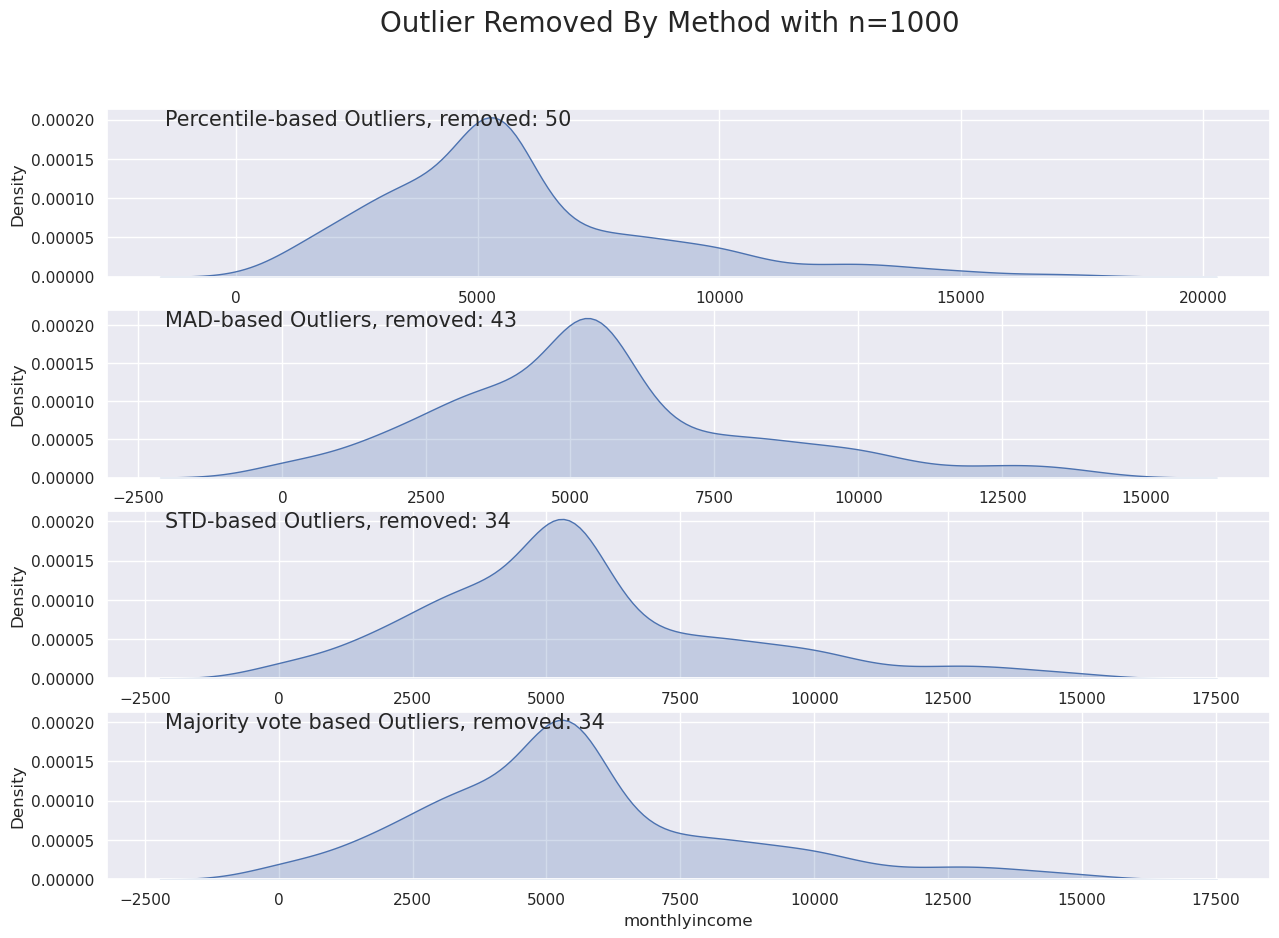

In [38]:
plotOutlierFree(training_data.monthlyincome.sample(1000))

In [39]:
# 이상치 데이터를 교체 로직 

def replaceOutlier(data, method=outlierVote, replace='median'):
    vote = outlierVote(data)
    x = pd.DataFrame(list(zip(data, vote)), columns=['debt', 'outlier'])
    if replace == 'median':
        replace_value = x.debt.median()
    elif replace == 'minUpper':
        replace_value = min([val for (val, vote) in zip(data, vote) if vote])
        if replace_value < data.mean():
            return 'There are outliers lower than the sample mean'
    debtNew = []
    for i in range(x.shape[0]):
        if x.iloc[i, 1]: 
            debtNew.append(replace_value)
        else:
            debtNew.append(x.iloc[i, 0])  
    
    return debtNew

In [40]:
incomeNew = replaceOutlier(training_data.monthlyincome, replace='minUpper')

In [41]:
training_data.monthlyincome = incomeNew

In [42]:
# collections.Counter(training_data.numberoftimes90dayslate)

In [43]:
def removeSpecificAndPutMedian(data, first = 98, second = 96):
    New = []
    med = data.median()
    for val in data:
        if ((val == first) | (val == second)):
            New.append(med)
        else:
            New.append(val)
            
    return New

In [44]:
new = removeSpecificAndPutMedian(training_data.numberoftimes90dayslate)

In [45]:
training_data.numberoftimes90dayslate = new

In [46]:
# collections.Counter(training_data.numberrealestateloansorlines)

In [47]:
realNew = []
for val in training_data.numberrealestateloansorlines:
    if val > 17:
        realNew.append(17)
    else:
        realNew.append(val)
training_data.numberrealestateloansorlines = realNew

In [48]:
# collections.Counter(training_data.numberoftime6089dayspastduenotworse)

In [49]:
new = removeSpecificAndPutMedian(training_data.numberoftime6089dayspastduenotworse)
training_data.numberoftime6089dayspastduenotworse = new

In [50]:
# collections.Counter(training_data.numberofdependents)

In [51]:
depNew = []
for var in training_data.numberofdependents:
    if var > 10:
        depNew.append(10)
    else:
        depNew.append(var)

In [52]:
training_data.numberofdependents = depNew

### Feature Importance

In [53]:
training_data.head()

,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,numberoftime3059dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime6089dayspastduenotworse,numberofdependents
0,1,0.766127,45,2.0,0.802982,9120.0,13,0.0,6,0.0,2.0
1,0,0.957151,40,0.0,0.121876,2600.0,4,0.0,0,0.0,1.0
2,0,0.658180,38,1.0,0.085113,3042.0,2,1.0,0,0.0,0.0
3,0,0.233810,30,0.0,0.036050,3300.0,5,0.0,0,0.0,0.0
4,0,0.907239,49,1.0,0.024926,16867.0,7,0.0,1,0.0,0.0


In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
training_data.columns[1:]

Index(['revolvingutilizationofunsecuredlines', 'age',
       'numberoftime3059dayspastduenotworse', 'debtratio', 'monthlyincome',
       'numberofopencreditlinesandloans', 'numberoftimes90dayslate',
       'numberrealestateloansorlines', 'numberoftime6089dayspastduenotworse',
       'numberofdependents'],
      dtype='object')

In [70]:
X = training_data.drop('seriousdlqin2yrs', axis=1)
y = training_data.seriousdlqin2yrs
features_label = training_data.columns[1:]

forest = RandomForestClassifier (n_estimators = 10000, random_state=0, n_jobs = -1,max_depth=2)
forest.fit(X,y)3

# 학습 이후
importances = forest.feature_importances_
indices = np. argsort(importances)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))

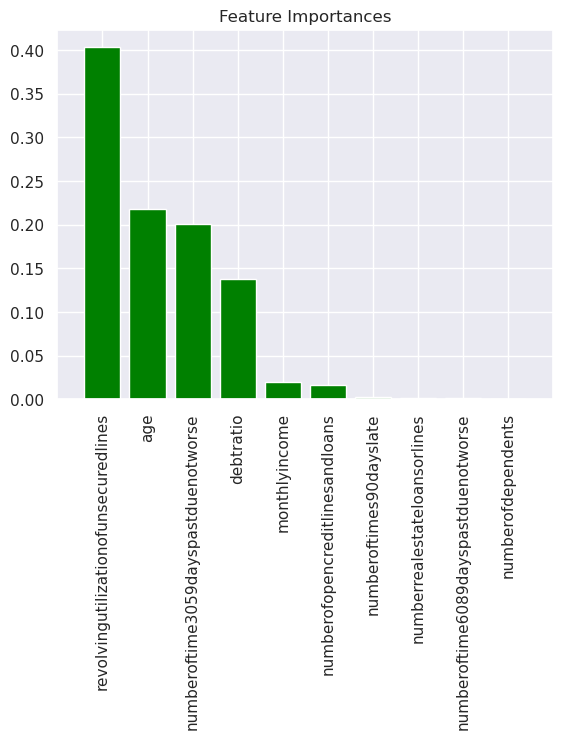

In [71]:
plt.title('Feature Importances')
plt.bar(range(X.shape[1]),importances[indices], color="green", align="center")
plt.xticks(range(X.shape[1]),features_label, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

---

## Train and build baseline model

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [75]:
X = training_data.drop('seriousdlqin2yrs', axis=1)
y = training_data.seriousdlqin2yrs
features_label = training_data.columns[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
knMod = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2,
                             metric='minkowski', metric_params=None)
knMod.fit(X_train, y_train)
# 학습 

knMod.score(X_test, y_test)


knMod.predict_proba(np.array(X_test.values))[:,1]




/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([0.2, 0. , 0. , ..., 0. , 0.4, 0. ])

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


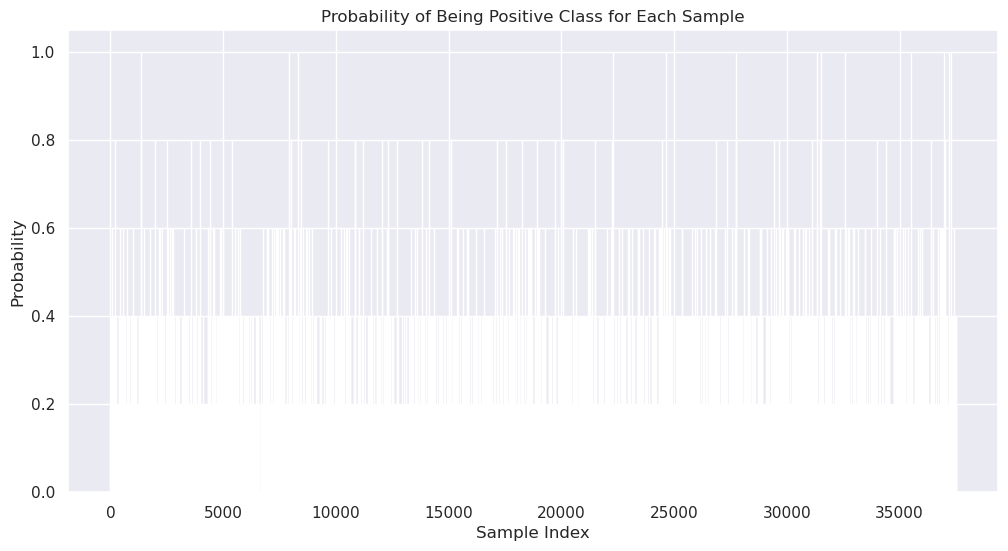

In [81]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(knMod.predict_proba(np.array(X_test.values))[:,1])),\
        knMod.predict_proba(np.array(X_test.values))[:,1], color='#ADD8E6')
plt.title('Probability of Being Positive Class for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.show()


# features_label 
# plt.bar(range(len(knMod.predict_proba(np.array(X_test.values))[:,1])), knMod.predict_proba(np.array(X_test.values))[:,1], color='skyblue')

In [73]:
glmMod = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
                            intercept_scaling=1, class_weight=None, 
                            random_state=None, solver='liblinear', max_iter=100,
                            multi_class='ovr', verbose=2)
glmMod.fit(X_train, y_train)
glmMod.score(X_test, y_test)
test_labels=glmMod.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 2
iter   5  #CD cycles 1
iter   6  #CD cycles 2
iter   7  #CD cycles 1
iter   8  #CD cycles 2
iter   9  #CD cycles 1
iter  10  #CD cycles 2
iter  11  #CD cycles 3
iter  12  #CD cycles 8
iter  13  #CD cycles 5
iter  14  #CD cycles 3
iter  15  #CD cycles 1
iter  16  #CD cycles 5
iter  17  #CD cycles 12
iter  18  #CD cycles 3
iter  19  #CD cycles 4
iter  20  #CD cycles 5
iter  21  #CD cycles 4
iter  22  #CD cycles 11
optimization finished, #iter = 22
Objective value = 21087.788580
#nonzeros/#features = 11/11


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.848757926135438

In [62]:
adaMod = AdaBoostClassifier(n_estimators=200, learning_rate=1.0)
adaMod.fit(X_train, y_train)
adaMod.score(X_test, y_test)
test_labels=adaMod.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


0.8641227547843977

### Cross Validation

In [63]:
from sklearn.model_selection import cross_val_score
def cvDictGen(functions, scr, X_train=X, y_train=y, cv=3, verbose=1):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, y_train, cv=cv, verbose=verbose, scoring=scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

def cvDictNormalize(cvDict):
    cvDictNormalized = {}
    for key in cvDict.keys():
        for i in cvDict[key]:
            cvDictNormalized[key] = ['{:0.2f}'.format((cvDict[key][0]/cvDict[cvDict.keys()[0]][0])),
                                     '{:0.2f}'.format((cvDict[key][1]/cvDict[cvDict.keys()[0]][1]))]
    return cvDictNormalized

In [70]:
cvD = cvDictGen(functions=[knMod, glmMod, adaMod], scr='roc_auc')
cvD

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 2
iter   5  #CD cycles 1
iter   6  #CD cycles 1
iter   7  #CD cycles 9
iter   8  #CD cycles 3
iter   9  #CD cycles 3
iter  10  #CD cycles 5
iter  11  #CD cycles 1
iter  12  #CD cycles 3
iter  13  #CD cycles 20
iter  14  #CD cycles 3
iter  15  #CD cycles 2
iter  16  #CD cycles 3
iter  17  #CD cycles 2
iter  18  #CD cycles 3
iter  19  #CD cycles 1
iter  20  #CD cycles 8
iter  21  #CD cycles 6
optimization finished, #iter = 21
Objective value = 18668.566494
#nonzeros/#features = 11/11
[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
iter   6  #CD cycles 3
iter   7  #CD cycles 1
iter   8  #CD cycles 2
iter   9  #CD cycles 4
iter  10  #CD cycles 1
iter  11  #CD cycles 5
iter  12  #CD cycles 2
iter  13  #CD cycles 2
iter  14  #CD cycles 2
iter  15  #CD cycles 2
iter  16  #CD cycles 3
iter  17  #CD cycles 1
iter  18  

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Hyper parameter optimization using Randomized search

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#### AdaBoost

In [72]:
adaHyperParams = {'n_estimators': [10,50,100]}

In [73]:
gridSearchAda = RandomizedSearchCV(estimator=adaMod, param_distributions=adaHyperParams, n_iter=3,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

In [97]:
gridSearchAda.best_params_, gridSearchAda.best_score_

#### GradientBoosting

In [98]:
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

In [99]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

In [100]:
gridSearchGB.best_params_, gridSearchGB.best_score_

### Train models with help of new hyper parameter

In [101]:
bestGbModFitted = gridSearchGB.best_estimator_.fit(X_train, y_train)

In [102]:
bestAdaModFitted = gridSearchAda.best_estimator_.fit(X_train, y_train)

In [103]:
cvDictbestpara = cvDictGen(functions=[bestGbModFitted, bestAdaModFitted], scr='roc_auc')

In [104]:
cvDictbestpara

In [105]:
test_labels=bestGbModFitted.predict_proba(np.array(X_test.values))[:,1]

In [106]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

In [107]:
test_labels=bestAdaModFitted.predict_proba(np.array(X_test.values))[:,1]

In [108]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

### Feature Transformation

In [110]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
X_train_1 = np.array(X_train)
X_train_transform = transformer.transform(X_train_1)

In [111]:
bestGbModFitted_transformed = gridSearchGB.best_estimator_.fit(X_train_transform, y_train)

In [112]:
bestAdaModFitted_transformed = gridSearchAda.best_estimator_.fit(X_train_transform, y_train)

In [113]:
cvDictbestpara_transform = cvDictGen(functions=[bestGbModFitted_transformed, bestAdaModFitted_transformed],
                                     scr='roc_auc')

In [114]:
cvDictbestpara_transform

In [115]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
X_test_1 = np.array(X_test)
X_test_transform = transformer.transform(X_test_1)



In [118]:
X_test_transform

In [119]:
test_labels=bestGbModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]

In [120]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

In [121]:
test_labels=bestAdaModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]

In [122]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

### Voting based ensamble model

In [ ]:
from sklearn.ensemble import VotingClassifier
votingMod = VotingClassifier(estimators=[('gb', bestGbModFitted_transformed), 
                                         ('ada', bestAdaModFitted_transformed)], voting='soft',weights=[2,1])
votingMod = votingMod.fit(X_train_transform, y_train)

In [140]:
test_labels=votingMod.predict_proba(np.array(X_test_transform))[:,1]

In [141]:
votingMod.score(X_test_transform, y_test)

In [142]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

In [143]:
from sklearn.ensemble import VotingClassifier
votingMod_old = VotingClassifier(estimators=[('gb', bestGbModFitted), ('ada', bestAdaModFitted)], 
                                 voting='soft',weights=[2,1])
votingMod_old = votingMod.fit(X_train, y_train)

In [144]:
test_labels=votingMod_old.predict_proba(np.array(X_test.values))[:,1]

In [145]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

### Testing on Real Test Dataset

In [ ]:
# Read Training dataset as well as drop the index column
test_data = pd.read_csv('./data/cs-test.csv').drop('Unnamed: 0', axis = 1)
# For each column heading we replace "-" and convert the heading in lowercase 
cleancolumn = []
for i in range(len(test_data.columns)):
    cleancolumn.append(test_data.columns[i].replace('-', '').lower())
test_data.columns = cleancolumn

In [ ]:
test_data.drop(['seriousdlqin2yrs'], axis=1, inplace=True)
test_data.fillna((training_data.median()), inplace=True)

In [ ]:
test_labels_votingMod_old = votingMod_old.predict_proba(np.array(test_data.values))[:,1]
print (len(test_labels_votingMod_old))

In [166]:
output = pd.DataFrame({'ID':test_data.index, 'probability':test_labels_votingMod_old})

In [167]:
output.to_csv("./predictions.csv", index=False)

In [168]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
test_data_temp = np.array(test_data)
test_data_transform = transformer.transform(test_data_temp)

In [169]:
test_labels_votingMod = votingMod.predict_proba(np.array(test_data.values))[:,1]
print (len(test_labels_votingMod_old))

In [170]:
output = pd.DataFrame({'ID':test_data.index, 'probability':test_labels_votingMod})

In [171]:
output.to_csv("./predictions_voting_Feature_transformation.csv", index=False)